# Assignment #1 - Linear Regression

<font color="red"> <b> Due: Oct 9 (Friday) 11:00 pm </b> </font>

<font color="blue"> Yike Li </font>

# Introduction

Describe the objective of this assignment. You can briefly state how you accompilsh it.

In this assignment, we are tasked to use two types of algorithms, Least Squares and Least Mean Squares (LMS), to solve the same linear regression problem. The Least Squares approach gives the closed form analytical solution for the regression equation. The LMS is an online learning approachwhich is suitable for large datasets. We are also to learn about the use of super class and the ways of inheritance in Python. 

In this assignment, I use the code framework provided in class. We are just to fill in the missing code and call the related methods (like train and use) within the class on our regression dataset for training and prediction. 

# Data

Introduce your data and visualize them. Describe your observations about the data.
You can reuse the regression data that you examined in Assignment #0.

This dataset comes from the load forecasting track of GEFCom2012 (Global Energy Forecasting Competition). During the competition, contestants were asked to forecast and backcast the electricity demand for 21 load zones, of which the Zone 21 was the sum of the other 20 zones. The entire data set consists of hourly load data of 20 zones from the 1st hour of 1/1/2004 to the 6th hour of 6/30/2008, with hourly temperature history from 11 anonymous weather stations ($T_1$-$T_{11}$). Since the dataset is huge, in this assignment, I only conduct the EDA using the Zone 11 data. 

Further details about GEFCom2012 can be found in this [link](http://blog.drhongtao.com/2016/07/gefcom2012-load-forecasting-data.html). 

In [1]:
# import
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

register_matplotlib_converters()

In [2]:
# Load the regression dataset, GEFCOM2012 load forecasting track, loads are in kW
user = 'Administrator'
zone_21 = pd.read_excel(
    f'C:/Users/{user}/Dropbox/Misc/ITCS 8156/GEFCom2012_zone 21.xlsx')

Here is how the dataset looks like, as well as the some of the basic statistics. This dataset is pre-cleaned and thus is ready for data visualization.

In [3]:
zone_21.head(3)

,zone_id,year,month,day,hour,load,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,weekday,date,T_ave
0,21,2004,1,1,1,1.397668,46,38,44,45,42,44,45,43,41,42,36,5,2004-01-01 00:00:00,42.363636
1,21,2004,1,1,2,1.351507,46,36,42,43,42,43,44,44,39,43,32,5,2004-01-01 01:00:00,41.272727
2,21,2004,1,1,3,1.315742,45,35,40,41,40,42,41,42,36,43,31,5,2004-01-01 02:00:00,39.636364


In [4]:
zone_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   zone_id  26304 non-null  int64         
 1   year     26304 non-null  int64         
 2   month    26304 non-null  int64         
 3   day      26304 non-null  int64         
 4   hour     26304 non-null  int64         
 5   load     26304 non-null  float64       
 6   T1       26304 non-null  int64         
 7   T2       26304 non-null  int64         
 8   T3       26304 non-null  int64         
 9   T4       26304 non-null  int64         
 10  T5       26304 non-null  int64         
 11  T6       26304 non-null  int64         
 12  T7       26304 non-null  int64         
 13  T8       26304 non-null  int64         
 14  T9       26304 non-null  int64         
 15  T10      26304 non-null  int64         
 16  T11      26304 non-null  int64         
 17  weekday  26304 non-null  int64 

Below shows the statistics (mean, standard deviation, minimum and maximum) of temperature recorded at each station. It can be seen the temperature values vary a wide range, particularly for the minimum temperature. The temperature is in the unit of Fahrenheit.

In [5]:
# Observe the temperature reported at each station
temperature_2012 = zone_21.iloc[:, 6:-3]
desc = temperature_2012.describe().loc[['mean', 'std', 'min', 'max']]
print(desc.T)

          mean        std   min    max
T1   59.671799  16.870646  12.0  103.0
T2   54.825274  17.241595   2.0   95.0
T3   56.122795  17.463694   8.0   97.0
T4   60.108082  17.369716  11.0  103.0
T5   56.915070  17.484062   6.0   99.0
T6   58.469016  16.963792   7.0   98.0
T7   58.716811  18.001334   8.0  101.0
T8   59.168530  17.651083   6.0  103.0
T9   56.654159  17.812373   5.0   99.0
T10  58.648114  17.281610   5.0  100.0
T11  55.018552  17.716102   0.0   97.0


Three years (2004-2006) of the hourly load plot at the aggregated load zone - $Z_{21}$ and hourly temperature plot obtained from the average of 11 temperature series, are plotted. We see very strong yearly seasonality for both the Load (up) and the Temperature (down). 

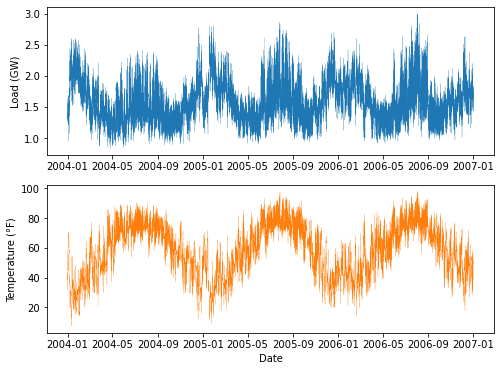

In [6]:
# 2012 Hourly Load and Temperature curve
plt.figure(figsize=(8, 6))
plt.subplot(211)  # Hourly load plot
plt.plot(zone_21.date, zone_21.load, lw=.2)
plt.ylabel('Load (GW)')
plt.subplot(212)  # Hourly temperature plot
plt.plot(zone_21.date, zone_21.T_ave, lw=.2, c='tab:orange')
plt.ylabel('Temperature (°F)')
plt.xlabel('Date')
plt.show()

Temperature is known to have a strong correlation with electricity usage patterns. Below shows the scatterplot of load – temperature relationship using three years of data (2004-2006) from the $Z_{21}$ and the average temperature from the 11 stations. The graph shows a strong correlation (the typical “hockey stick” shape) between the load and temperature. On the left arm, the load goes up for heating needs during the winter when the temperature drops below a certain point. On the right arm, the load goes up for cooling needs during the summer when the temperature increases. This scatterplot shows that there is a cutoff point at around 60 °F.

Also a third order polynomial line is fitted in the plot. 

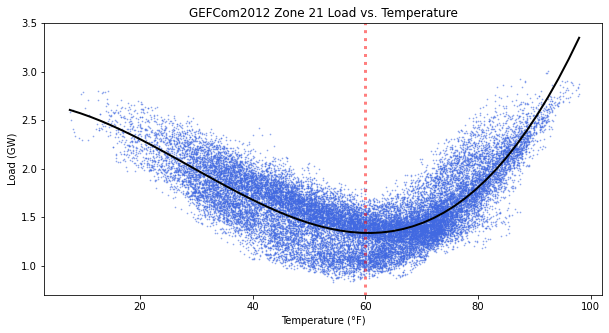

In [7]:
# 2012 Load vs. Temperature w/ fitted curve
from numpy.polynomial.polynomial import polyfit, polyval

plt.figure(figsize=(10, 5))
plt.scatter(zone_21.T_ave, zone_21.load, s=0.5,
            alpha=0.5, marker="o", c='royalblue')
plt.axvline(x=60, color='red', linestyle=':', alpha=0.5,
            linewidth=3)  # vertical dotted line
plt.title('GEFCom2012 Zone 21 Load vs. Temperature')
coefs = polyfit(zone_21.T_ave, zone_21.load, 3)  # fit 3rd order polynomial
x_new = np.linspace(min(zone_21.T_ave), np.max(zone_21.T_ave))
ffit = polyval(x_new, coefs)
plt.plot(x_new, ffit, '-', c='black', linewidth=2)
plt.xlim(3, 102)
plt.ylim(.7, 3.5)
plt.xlabel('Temperature (°F)')
plt.ylabel('Load (GW)')
plt.show()

To model the annual seasonality, the categorical variables – month, have been included to categorize load patterns throughout the year. The figure below gives the scatterplots of load – temperature relationship at each month of a year from the aggregated zone and the average temperature from the 11 stations in this case study. The correlation between the load and temperature during the winter months (Month=12, 1, 2, 3) and summer months (Month=6, 7, 8, 9) is stronger than the remaining months, largely due to during these 6 months, load tends to increase when the weather (temperature here) gets extreme. In the remaining 4 months (Month=4, 5, 10, 11), the relationship between the two is weak.

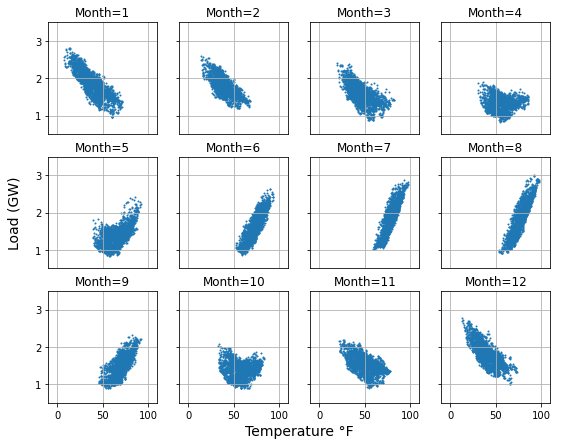

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex='col',
                       sharey='row', figsize=(9, 7))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False,
                bottom=False, left=False, right=False)
# plt.rcParams['ytick.labelsize'] = 10
plt.xlabel('Temperature °F', fontsize=14)
plt.ylabel('Load (GW)', fontsize=14)
# fig.suptitle('Load vs. Temperature by Month')
for i in range(4):  # col
    for j in range(3):  # row
        ax[j, i].scatter(zone_21.loc[zone_21['month'] == i + j * 4 + 1].T_ave,
                         zone_21.loc[zone_21['month'] == i + j * 4 + 1].load, s=1)
        ax[j, i].set_title('Month=' + str(i + j * 4 + 1), fontsize=12)
        # set xlim and ylim for each subplot
        ax[j, i].set(xlim=(-10, 110), ylim=(0.5, 3.5))
        ax[j, i].grid(True)  # add gridlines
        if j != 2:
            ax[j, i].xaxis.set_ticks_position('none')  # remove xsticks
plt.show()

# Method 

Summarize the linear models (least-squares and LMS) and explain your implementation of **class** *LinearModel*. 
The explanation of your codes should not be the comments in a code cell. 
This section should include
 - review of the linear models
 - your implementation and description

**Review of the linear models:**
- The least-squares method is a standard approach in regression analysis to approximate the solution of a set of equations, in which there are more equations than unknowns. The least-squares method minimizes the loss function, which is the sum of the squares of the residuals. This estimation procedure is not suitable for a large dataset. If there is perfect collinearity among the predictors, the design matrix will become singular and its inversion is not available. 
- The LMS method is an online learning algorithm, which takes one data sample at a time and update the weight parameters from the error in the previous iteration. This process can be used to cope with large dataset where the least-squares method is not suitable. It is worth mentioning that the hyperparameter of learning rate needs to be tuned for ideal convergence rate.

**My implementation and description:**

My implementation basically fills up the method blocks from the hints provided in the class reading assignment. Concretely, the `BaseModel` is machine learning models class at the top of the hierarchy (the parent class for all the child classes). The `LinearModel` inheritates from the parent class `BaseModel` and it includes two abstract methods, `train` and `use`. The abstract methods are declared in the class, but will be replaced by the methods declared in the two subclasses: `LinearRegress` and `LMS`. At last, `LinearRegress` and `LMS` provide the detail implementations for training the linear regression model and testing on the data.

### Super Class Definition

In [9]:
from abc import ABC, abstractmethod

In [10]:
# Superclass for machine learning models
class BaseModel(ABC):

    @abstractmethod  # 使用@abstractmethod来将方法标记为抽象的 —— 这些方法将在子类中必须实现。
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

In [11]:
# LinearModel从BaseModel类继承。BaseModel是其父类，LinearModel是BaseModel的子类。https://zhuanlan.zhihu.com/p/40446047
# 这个LinearModel仍然是抽象类，它（此时为父类）的两个子类，LinearRegress和LMS，再来定义各自具体的train和use方法。


class LinearModel(BaseModel):
    """ Abstract class for a linear model 

        attributes
        ==========
        w       ndarray
                weight vector/matrix
    """
    # initialization

    def __init__(self):
        """
            weight vector w is initialized as None
        """
        self.w = None  # 初始化w为None

    # check if the matrix is 2-dimensional. if not, raise an exception. 判断输入是2维的。
    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))

    # add a basis
    def add_ones(self, X):
        """ 
            add a column basis to X input matrix 
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    @abstractmethod
    def train(self, X, T):
        """ Train linear model

            parameters
            -----------
            X     2d array
                  input data
            T     2d array
                  target labels
        """
        pass

    @abstractmethod
    def use(self, X):
        """
            apply the learned model to input X

            parameters
            ----------
            X     2d array
                  input data
        """
        pass

### Least Squares

In [12]:
# Linear Regression Class for least squares
class LinearRegress(LinearModel):
    """ LinearRegress class 

        attributes
        ===========
        w    nd.array  (column vector/matrix)
             weights
    """
    # initialization

    def __init__(self):
        LinearModel.__init__(self)  # 沿用LinearModel的__init__, 对w初始化

    # train lease-squares model
    def train(self, X, T):
        X = self.add_ones(X)
        self.w = np.linalg.inv(X.T @ X) @ X.T @ T
        pass

    # apply the learned model to data X
    def use(self, X):
        X = self.add_ones(X)
        output = X @ self.w
        return output.reshape((-1, 1))

### Least Mean Squares

In [13]:
import collections  # for checking iterable instance

In [14]:
# LMS class
class LMS(LinearModel):
    """ Lease Mean Squares. online learning algorithm

        attributes
        ==========
        w        nd.array
                 weight matrix
        alpha    float
                 learning rate
    """

    def __init__(self, alpha):
        LinearModel.__init__(self)  # 沿用LinearModel的__init__, 对w初始化
        self.alpha = alpha  # 定义学习率

    # batch training by using train_step function
    def train(self, X, T):
        self.w = np.zeros(len(X[0])+1)
        for x, t in zip(X, T):
            self.train_step(x, t)
        pass

    # train LMS model one step
    # here the x is 1d vector
    def train_step(self, x, t):
        if self.w is None:
            # 对w初始化，都设为0, 加1是因为要加一列全1的变量。因为LMS每次训练用1个sample，x这里是1个sample，维数由变量个数决定，所以是个1d vector
            self.w = np.zeros(len(x)+1)
        x1 = np.append(np.array([1]), x)  # 给x向量前面加上个“1”
        y = self.w @ x1
        self.w -= self.alpha * (y - t) * x1
        pass

    # apply the current model to data X
    def use(self, X):
        X = self.add_ones(X)
        output = X @ self.w
        return output.reshape((-1, 1))

### Usage Examples

Below tests the least square method. We can tell the fitted results are exactly the same as the original data. 

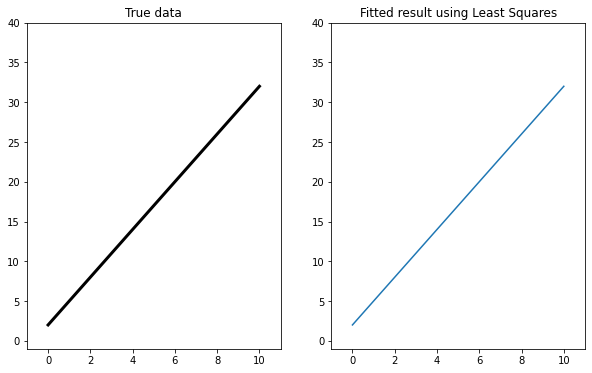

In [15]:
# The following are to test the code
fig = plt.figure(figsize=(10, 6))
plt.subplot(121)
X = np.linspace(0, 10, 21).reshape((-1, 1))
T = 3 * X + 2
plt.plot(X, T, linewidth=3, color='black')
plt.title('True data')
plt.xlim(-1, 11)
plt.ylim(-1, 40)

plt.subplot(122)
ls = LinearRegress()  # least squares regression
ls.train(X, T)
plt.plot(X, ls.use(X))
plt.title('Fitted result using Least Squares')
plt.xlim(-1, 11)
plt.ylim(-1, 40)
plt.show()

Below tests the least mean square method. We can tell the fitted results getting closer to the original data as the iteration grows. At the last iteration, the fitted line is pretty close to the true line. 

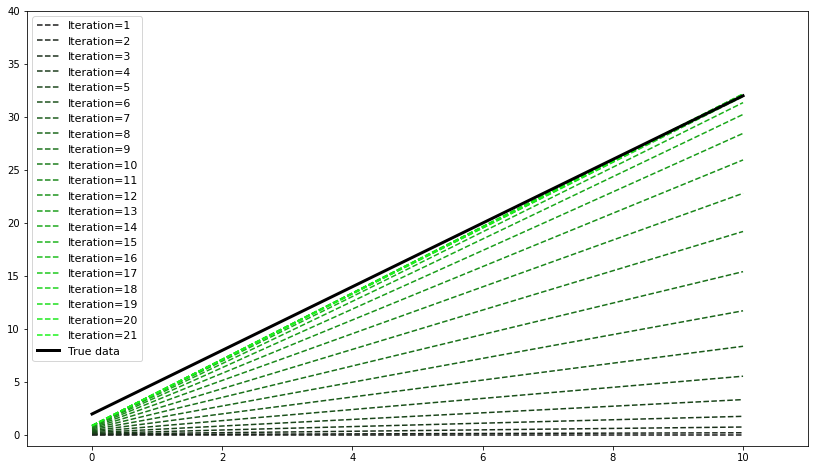

In [16]:
import IPython.display as ipd

fig = plt.figure(figsize=(14, 8))
lms = LMS(0.01)  #
green = 0.1
count = 1

for x, t in zip(X, T):
    lms.train_step(x, t)
    plt.plot(X, lms.use(X), linestyle='dashed', c=(
        0.1, green, 0.1, 1), label=f'Iteration={count}')
    plt.xlim(-1, 11)
    plt.ylim(-1, 40)
    green += (1 - 0.1) / (len(X))
    count += 1
    # Clear the output of the current cell receiving output. Wait to clear the output until new output is available to replace it.
    ipd.clear_output(wait=True)
    ipd.display(fig)
# this is the clear the output again such that we won't see two pics
plt.plot(X, T, linewidth=3, color='black', label='True data')
plt.xlim(-1, 11)
plt.ylim(-1, 40)
plt.legend(loc='best', prop={'size': 11})
ipd.clear_output(wait=True)

Below I also test the lms.train method, which is a wrapper of the lms.train_step. It shows very close result to the true line. 

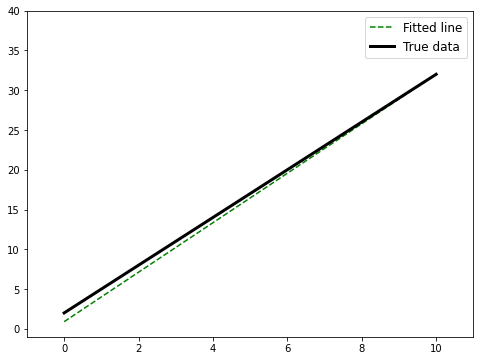

In [17]:
fig = plt.figure(figsize=(8, 6))
lms.train(X, T)
plt.plot(X, lms.use(X), linestyle='dashed', c='green', label='Fitted line')
plt.plot(X, T, linewidth=3, color='black', label='True data')
plt.xlim(-1, 11)
plt.ylim(-1, 40)
plt.legend(loc='best', prop={'size': 12})

# Experiments

Apply LS and LMS methods on the data and discuss the results.
Please describe your experiment and related codes. You may have subsections of results and discussions here.

In this section, we will hold out a year worth of load data in the aforementioned dataset as the validation data. We will use the two methods (Least Square and Least Mean Square) to fit the training data and predict on the validation period. We want to see which method achieves better performance on the training data (training error, in RMSE) and we are more interested in the error on the validation data (validation error, in RMSE). 

Before we split the data into training and validation set, we want to conduct some feature engineering first. In the dataset, the temperature data is provided at 11 weather stations. We get the average of all reported temperature (as $T$) and compute the $T^2, T^3$ to form up the design matrix. Also to model the annual seasonality, the categorical variables – month, have been included to categorize load patterns throughout the year. We use `pd.get_dummies` with `drop_first`=`True` option to generate the dummy variables for "month". 

In [18]:
def normalize(X):
    """
    normalize the dataframe. 
    """
    mu = X.mean()
    std = X.std()
    return (X - mu) / std


# Preprocessing
zone_21.rename(columns={'T_ave': 'T'}, inplace=True)
zone_21['T_sq'] = zone_21['T'] ** 2
zone_21['T_cb'] = zone_21['T'] ** 3
# for training
zone_21_tr = zone_21[zone_21.year != 2006]
zone_21_tr = zone_21_tr[['load', 'month', 'T', 'T_sq', 'T_cb']]
zone_21_tr = pd.get_dummies(zone_21_tr, prefix=['month'], columns=[
                            'month'], drop_first=True)
zone_21_tr = normalize(zone_21_tr)
# for validation/testing
zone_21_test = zone_21[zone_21.year == 2006]
zone_21_test = zone_21_test[['load', 'month', 'T', 'T_sq', 'T_cb']]
zone_21_test = pd.get_dummies(zone_21_test, prefix=['month'], columns=[
                              'month'], drop_first=True)
zone_21_test = normalize(zone_21_test)

X_tr, X_test, Y_tr, Y_test = zone_21_tr.iloc[:, 1:].to_numpy(), zone_21_test.iloc[:, 1:].to_numpy(), \
    zone_21_tr.iloc[:, 0].to_numpy(), zone_21_test.iloc[:, 0].to_numpy()

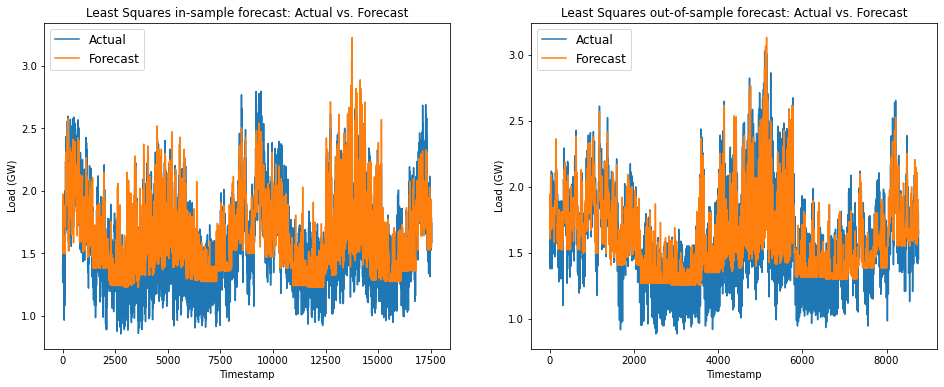

The RMSE on Training set is: 0.4656
The RMSE on Test set is: 0.4579


In [19]:
# Least squares
ls = LinearRegress()  # least squares regression
ls.train(X_tr, Y_tr)
Y_tr_pred_denormalized = ls.use(
    X_tr) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_tr_denormalized = Y_tr * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_pred_denormalized = ls.use(
    X_test) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_denormalized = Y_test * np.std(zone_21.load) + np.mean(zone_21.load)

fig = plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(Y_tr_denormalized, label='Actual')
plt.plot(Y_tr_pred_denormalized, label='Forecast')
plt.title('Least Squares in-sample forecast: Actual vs. Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Load (GW)')
plt.legend(loc='upper left', prop={'size': 12})

plt.subplot(122)
plt.plot(Y_test_denormalized, label='Actual')
plt.plot(Y_test_pred_denormalized, label='Forecast')
plt.title('Least Squares out-of-sample forecast: Actual vs. Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Load (GW)')
plt.legend(loc='upper left', prop={'size': 12})
# plt.tight_layout()
plt.show()

# calculate RMSE
tr_RMSE = np.sqrt(np.mean((Y_tr_pred_denormalized - Y_tr_denormalized) ** 2))
print(f'The RMSE on Training set is: {tr_RMSE:.4}')
test_RMSE = np.sqrt(np.mean((Y_test_pred_denormalized - Y_test_denormalized) ** 2))
print(f'The RMSE on Test set is: {test_RMSE:.4}')

From the above we can see the in-sample forecast captures some but not all patterns in the historical data. Also the RMSE's on the training and test set are provided, which are pretty close. Now we try using the LMS method and check the outcome. 

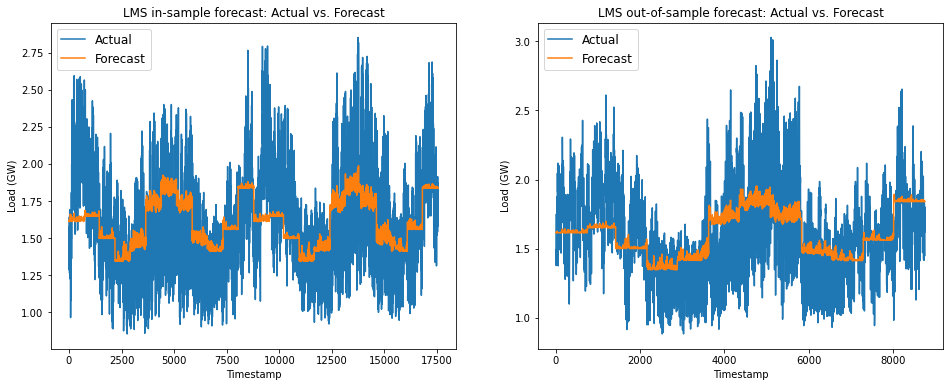

The RMSE on Training set is: 0.3907
The RMSE on Test set is: 0.3915


In [20]:
# LMS
lms = LMS(0.0001)  # least squares regression

lms.train(X_tr, Y_tr)
Y_tr_pred_denormalized = lms.use(X_tr) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_tr_denormalized = Y_tr * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_pred_denormalized = lms.use(X_test) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_denormalized = Y_test * np.std(zone_21.load) + np.mean(zone_21.load)

fig = plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(Y_tr_denormalized, label='Actual')
plt.plot(Y_tr_pred_denormalized, label='Forecast')
plt.title('LMS in-sample forecast: Actual vs. Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Load (GW)')
plt.legend(loc='upper left', prop={'size': 12})

plt.subplot(122)
plt.plot(Y_test_denormalized, label='Actual')
plt.plot(Y_test_pred_denormalized, label='Forecast')
plt.title('LMS out-of-sample forecast: Actual vs. Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Load (GW)')
plt.legend(loc='upper left', prop={'size': 12})
# plt.tight_layout()
plt.show()

tr_RMSE = np.sqrt(np.mean((Y_tr_pred_denormalized - Y_tr_denormalized) ** 2))
print(f'The RMSE on Training set is: {tr_RMSE:.4}')

test_RMSE = np.sqrt(np.mean((Y_test_pred_denormalized - Y_test_denormalized) ** 2))
print(f'The RMSE on Test set is: {test_RMSE:.4}')

The learning rate - $\alpha$, was tuned by hand to achieve a better in-sample training error. We can tell that the RMSE on training and test set under the LMS method are both lower than the Least Squares method. From the code block execution time, The LMS method takes 4.16s and the Least Squares takes 4.23s, which are pretty close to each other. 

# Conclusions

Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 

I was facing the challenge on the convergence of the LMS algorithm when the normalization was not applied. No matter what $\alpha$ I have assigned, the algorithm won't be able to converge. Then I tried the normalization introduced in class, which is to take subtraction of the mean and then dividing by its standard deviation for each input variable. At the end the algorithm was able to converge at most assigned $\alpha$ values. 

Also one thing about normalization is that when we use RMSE as the error metrics, we need to rescale (denormalize) the predicted values such that the RMSE can be calculated correctly. 

I also learned a lot about the object oriented programming from this homework. The results show my implmentation of LinearRegress and LMS classes has passed preliminary test successfully. 

# References

(1). GEFCom2012 data. Retrieved from http://blog.drhongtao.com/2016/07/gefcom2012-load-forecasting-data.html

# Extra Credit

If you want to work more for an extra credit, place your work here for additional analysis: weight and residual analysis. 
Try to answer to the following questions: 
- what is the most and least significant features for your data.
- what are the consequences if you remove those features from the model? (Show your work!)
- produce residual plots and observe the patterns for the goodness of fit    
    
**Note: the extra credit is an additional work that needs complete programming, experiments, analysis, and writing to get one. **

Since the data has been standardized (subtract the mean, then divide by the standard deviation) before the training step, we can compare the standardized coefficients (the weights) and determine which **continuous** variable is more significant than the others. Standardized coefficients represent the mean change in the response given a one standard deviation change in the predictor. The estimates of continuous variables below suggests the its influence to the load under each "Month" category. 

Take the Least Squares algorithm as an example. The below shows the weights for each variable. For the continuous variables other than the "Intercept" ("T", "T_sq" and "T_cb"), **the T_cb (cubed hourly temperature) gives the largest absolute estimate and should be considered as the most significant feature under this model setup. The T (hourly temperature) has the smallest absolute estimate and thus can be considered as the least significant feature.**

In [21]:
param_names = zone_21_tr.columns.to_list()[1:]  # convert var names to list
param_names.insert(0, 'Intercept')  # add intercept at the beginning
ls_weights = pd.Series(ls.w, index=param_names)  # form a pandas series
ls_weights  # print the pandas series

Intercept   -3.754635e-14
T           -3.871536e-01
T_sq        -4.150188e+00
T_cb         4.676842e+00
month_2     -2.104216e-02
month_3     -9.135062e-02
month_4     -1.968391e-01
month_5     -2.089002e-01
month_6     -1.334214e-01
month_7     -1.069389e-01
month_8     -8.606947e-02
month_9     -1.615741e-01
month_10    -1.745398e-01
month_11    -1.067665e-01
month_12     2.096628e-02
dtype: float64

Let's take a look at the impact of removing either T_cb or T from the model. 

In [22]:
# remove T_cb and T
X_tr_re_Tcb = np.delete(X_tr, 2, 1)  # delete 3rd column of X_tr, T_cb
X_test_re_Tcb = np.delete(X_test, 2, 1)  # delete 3rd column of X_test
X_tr_re_T = np.delete(X_tr, 0, 1)  # delete 1st column of X_tr, T
X_test_re_T = np.delete(X_test, 0, 1)  # delete 1st column of X_test, T

# remove T_cb and train
ls.train(X_tr_re_Tcb, Y_tr)
Y_tr_pred_denormalized = ls.use(X_tr_re_Tcb) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_tr_denormalized = Y_tr * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_pred_denormalized = ls.use(X_test_re_Tcb) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_denormalized = Y_test * np.std(zone_21.load) + np.mean(zone_21.load)
# calculate RMSE
tr_RMSE = np.sqrt(np.mean((Y_tr_pred_denormalized - Y_tr_denormalized) ** 2))
print(f'The RMSE on Training set (remove T_cb) is: {tr_RMSE:.4}')
test_RMSE = np.sqrt(np.mean((Y_test_pred_denormalized - Y_test_denormalized) ** 2))
print(f'The RMSE on Test set (remove T_cb) is: {test_RMSE:.4}')

# remove T and train
ls.train(X_tr_re_T, Y_tr)
Y_tr_pred_denormalized = ls.use(X_tr_re_T) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_tr_denormalized = Y_tr * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_pred_denormalized = ls.use(X_test_re_T) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_denormalized = Y_test * np.std(zone_21.load) + np.mean(zone_21.load)
# calculate RMSE
tr_RMSE = np.sqrt(np.mean((Y_tr_pred_denormalized - Y_tr_denormalized) ** 2))
print(f'The RMSE on Training set (remove T) is: {tr_RMSE:.4}')
test_RMSE = np.sqrt(np.mean((Y_test_pred_denormalized - Y_test_denormalized) ** 2))
print(f'The RMSE on Test set (remove T) is: {test_RMSE:.4}')

The RMSE on Training set (remove T_cb) is: 0.4618
The RMSE on Test set (remove T_cb) is: 0.4503
The RMSE on Training set (remove T) is: 0.4656
The RMSE on Test set (remove T) is: 0.4582


We use a table to summarize the results. We observe that removing T_cb can improve both the training and test RMSE from the original model (all variables). Removing T leads to the same performance as the original model on the training set, but results in inferior performance than the original model on the test set. 

| Case | Training RMSE | Test RMSE |
|:--- |:---:|:---:|
| All variables | 0.4656 | 0.4579 |
| Remove $T^3$ | 0.4618 | 0.4503 |
| Remove $T$ | 0.4656 | 0.4582 |

Thereafter, we plot the residuals of the test year (2006) as well as the residuals under the first week of 2006 under the original model below. The strong seasonality trend during each day of the week suggests our model has not been able to capture enough information from the historical data. Since the electricity consumption during each hour of the day may be different because of the human habits, we should consider adding "hour" as a categorical variable in our model. 

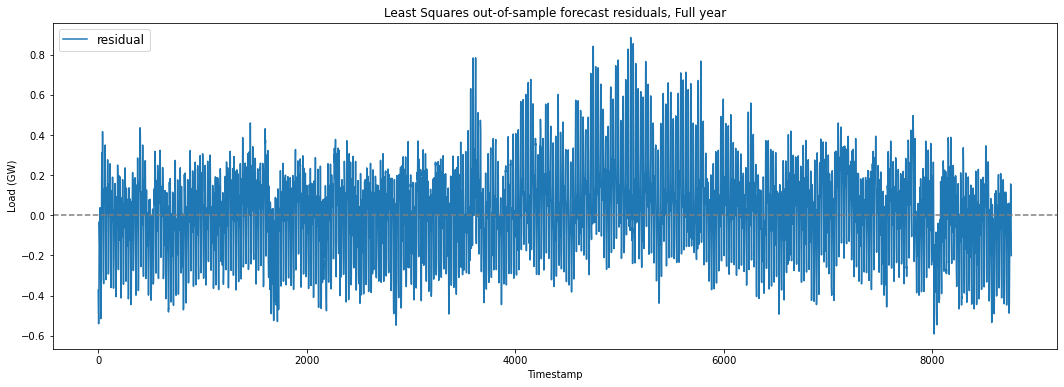

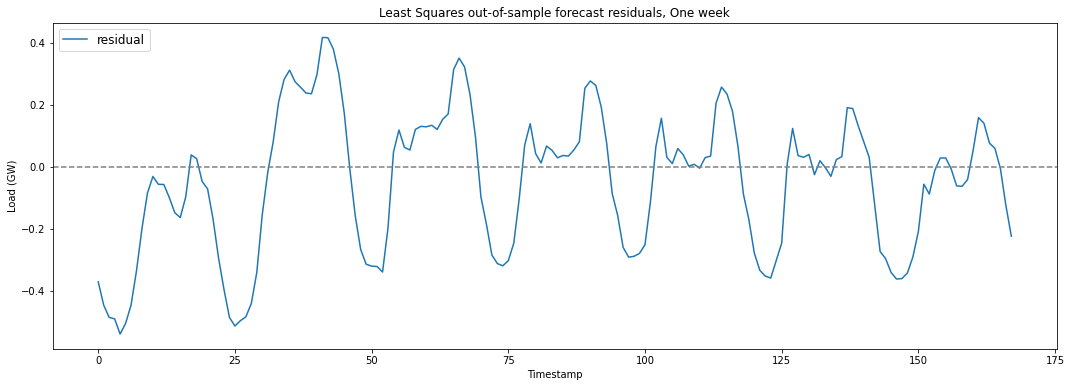

In [23]:
ls = LinearRegress()  # least squares regression
ls.train(X_tr, Y_tr)
Y_tr_pred_denormalized = ls.use(
    X_tr) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_tr_denormalized = Y_tr * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_pred_denormalized = ls.use(
    X_test) * np.std(zone_21.load) + np.mean(zone_21.load)
Y_test_denormalized = Y_test * np.std(zone_21.load) + np.mean(zone_21.load)

# plot the residuals
fig = plt.figure(figsize=(18, 6))
residual = Y_test_denormalized.flatten() - Y_test_pred_denormalized.flatten()
plt.plot(residual, label='residual')
plt.title('Least Squares out-of-sample forecast residuals, Full year')
plt.xlabel('Timestamp')
plt.ylabel('Load (GW)')
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend(loc='upper left', prop={'size': 12})

fig = plt.figure(figsize=(18, 6))
plt.plot(residual[:24*7], label='residual')
plt.title('Least Squares out-of-sample forecast residuals, One week')
plt.xlabel('Timestamp')
plt.ylabel('Load (GW)')
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend(loc='upper left', prop={'size': 12})

## Grading

<font color="blue"> DO NOT forget to submit your data! Your notebook is supposed to run well after running your codes. 

** Note: this is a WRITING assignment. Proper writing is REQUIRED. Comments are not considered as writing. ** 


Points | | Description
--|--|:--
5 | Introduction  
20 | Data | 
 | 5| description 
 | 5| plots for understanding or analysis 
 | 5| preliminary observation 
 | 5| Preprocessing of the data 
40 | Method | 
 | 5| review
 | 5| explanation of codes
 | 30| Correct implementation (preliminary test)
30 | Experiments | 
 | 5| description, codes
 | 10| visualization of results
 | 15| analysis / comparison of algorithms
5 | Conclusions, References 

# Preliminary Test

<font color="blue"> After finishing the implmentation of LinearRegress and LMS classes, run the following cell to test if your implementation is correct. Make sure and check your codes to pass all three tests as in sample outputs. 

In [24]:
##### ##### WHAT I WILL RELEASE ##### #####

# Self-Test code for accuracy of your model - DO NOT MODIFY THIS
# Primilnary test data
X = np.array([[2, 5],
              [6, 2],
              [1, 9],
              [4, 5],
              [6, 3],
              [7, 4],
              [8, 3]])
T = X[:, 0, None] * 3 - 2 * X[:, 1, None] + 3
N = X.shape[0]


def rmse(T, Y):
    return np.sqrt(np.sum((T-Y)**2)/T.shape[0])


model_names = ['LS', 'LMS_All', 'LMS_1STEP']
models = [LinearRegress(), LMS(0.02), LMS(0.02)]

# train
for i, model in enumerate(models):
    print("training ", model_names[i], "...")
    if i == len(models) - 1:
        # train only one step for LMS2
        model.train_step(X[0], T[0])
    else:
        model.train(X, T)


def check(a, b, eps=np.finfo(float).eps):
    if a-b > 0:
        print("failed.", a, b)
    else:
        print("passed.")


errors = [1.19e-13, 2.8753214702, 38.0584918251]
for i, model in enumerate(models):
    print("---- Testing ", model_names[i], "...", end=" ")

    # rmse test
    err = rmse(T, model.use(X))
    if check(err, errors[i], eps=1e-10):
        print("check your weights: ", model.w)
        print("oracle: ", )

training  LS ...
training  LMS_All ...
training  LMS_1STEP ...
---- Testing  LS ... passed.
---- Testing  LMS_All ... passed.
---- Testing  LMS_1STEP ... passed.
